In [24]:
!pip install dgl

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 59.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 6.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 20.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 19.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 KB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 12.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 7.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
zfit 0.20.3 requires colorama, which is not installed.
zfit 0.20.3 requires colored, which is not installed.
zfit 0.20.3 requires frozendict, which is not installed.
zfit 0.20.3 requires jacobi, which is not installed.
zfit 0.20.3 requires numdifftools, which is not installed.
zfit 0.20.3 requires ordered-set, which is not installed.
zfit 0.20.3 requires texttable, which is not installed.
zfit 0.20.3 requires zfit-interface, which is not installed.
tensorflow 2.12.0 requires gast<=0.4.0,>=0.2.1, but you have gast 0.5.2 which is incompatible.
zfit 0.20.3 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.12.0 which is incompatible.
ydata-profiling 4.6.5 requires pydantic>=2, but you have pydan

In [40]:
!pip install dgl==0.6.1


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 25.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: dgl
    Found existing installation: dgl 2.1.0
    Uninstalling dgl-2.1.0:
      Successfully uninstalled dgl-2.1.0


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import awkward as ak
import uproot

# Load data
file = uproot.open("/eos/user/h/hsharma/PythiaFIles/Cascades_Xi/cascade_data.root")
tree = file["cascade_tree"]
data = tree.arrays(library="ak")
data = data[:5000]

# Extract relevant features
px = ak.to_numpy(data["px"])
py = ak.to_numpy(data["py"])
pz = ak.to_numpy(data["pz"])
charge = ak.to_numpy(data["charge"])

# Create a node feature matrix
node_features = np.column_stack((px, py, pz, charge))

# Number of nodes
num_nodes = node_features.shape[0]

# Create an edge list for a fully connected graph
edges = np.array([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j]).T

# Convert edge index to PyTorch tensor
edge_index_tensor = torch.tensor(edges, dtype=torch.long)

# Ensure undirected edges
edge_index_tensor = torch.cat([edge_index_tensor, edge_index_tensor.flip(0)], dim=1)

# Convert node features to tensor
node_features_tensor = torch.tensor(node_features, dtype=torch.float)

# Ensure everything is on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create PyG Data object
graph_data = Data(x=node_features_tensor, edge_index=edge_index_tensor).to(device)

# Define the GNN model
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.fc = nn.Linear(output_dim, 1)  # Regression output (single value per node)
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

#     def forward(self, data):
#         x = self.conv1(data.x, data.edge_index)
#         x = torch.relu(x)
#         x = self.conv2(x, data.edge_index)
#         x = self.output_layer(x)  # Linear layer
#         x = self.sigmoid(x)  # Apply sigmoid here
#         return x


    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)
        return x

# Define model, optimizer, and loss function
model = GNN(input_dim=4, hidden_dim=64, output_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.MSELoss()
# loss_fn = nn.CrossEntropyLoss()

# Generate synthetic target values (for example purposes)
# Ideally, you should use actual data labels instead of ones.
target_values = torch.ones((num_nodes, 1), dtype=torch.float, device=device)

# Training function
def train(model, data, optimizer, loss_fn, epochs=500):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)

        # Ensure output and target have the same shape
        loss = loss_fn(out, target_values)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Run training
train(model, graph_data, optimizer, loss_fn)


Epoch 0, Loss: 0.10835482180118561
Epoch 10, Loss: 0.009253941476345062
Epoch 20, Loss: 0.00033967450144700706
Epoch 30, Loss: 0.0002434186899336055
Epoch 40, Loss: 0.000351965194568038
Epoch 50, Loss: 0.00016729801427572966
Epoch 60, Loss: 5.0019931222777814e-05
Epoch 70, Loss: 6.189429768710397e-06
Epoch 80, Loss: 5.479332116919977e-07
Epoch 90, Loss: 3.4585034427436767e-06
Epoch 100, Loss: 1.1046533927583368e-06
Epoch 110, Loss: 4.5870777398704377e-08
Epoch 120, Loss: 1.936658975409955e-07
Epoch 130, Loss: 1.649159836469849e-10
Epoch 140, Loss: 2.0266165634552635e-08
Epoch 150, Loss: 4.368715167402115e-09
Epoch 160, Loss: 6.482093334314598e-11
Epoch 170, Loss: 4.58307475303954e-10
Epoch 180, Loss: 3.3410191280225376e-10
Epoch 190, Loss: 1.412569089476179e-10
Epoch 200, Loss: 6.003335328852444e-11
Epoch 210, Loss: 2.702847667901409e-11
Epoch 220, Loss: 7.759628009584851e-12
Epoch 230, Loss: 1.7313311157993172e-12
Epoch 240, Loss: 1.3239741334519772e-12
Epoch 250, Loss: 1.437700761393

In [7]:
# Assuming you have a dataset `data` and want to split it
from sklearn.model_selection import train_test_split

# Create a mask for training and validation sets (80% training, 20% validation)
train_mask, val_mask = train_test_split(range(node_features.shape[0]), test_size=0.2)

# Create training and validation data objects
train_data = Data(x=node_features_tensor[train_mask], edge_index=edge_index_tensor[:, train_mask])
val_data = Data(x=node_features_tensor[val_mask], edge_index=edge_index_tensor[:, val_mask])

# Ensure the data is on the same device as the model
train_data = train_data.to(device)
val_data = val_data.to(device)

num_val_nodes = val_data.x.shape[0]  # Should be 200

# Create a fully connected edge index for 200 nodes
edge_index_val = torch.tensor(
    [[i, j] for i in range(num_val_nodes) for j in range(num_val_nodes) if i != j], dtype=torch.long
).T

# Update val_data
val_data.edge_index = edge_index_val.to(device)

print("✅ Fixed edge index for val_data!")


✅ Fixed edge index for val_data!


In [8]:
def evaluate(model, val_data, loss_fn):
    model.eval()
    with torch.no_grad():
        out = model(val_data)
        print(f"Raw model output (first 10 values): {out[:10].cpu().numpy().flatten()}")  # Debugging

        target = torch.ones_like(out).to(out.device)  
        loss = loss_fn(out, target)
        print(f"Validation Loss: {loss.item()}")

        return out, loss.item()

# # Evaluate the model on the validation set
predictions, val_loss = evaluate(model, val_data, loss_fn)

# Check if the indices in edge_index are valid
# num_nodes = val_data.x.size(0)
# assert (val_data.edge_index.min() >= 0).item(), "Edge index contains negative values."
# assert (val_data.edge_index.max() < num_nodes).item(), f"Edge index contains out-of-bounds values (max: {val_data.edge_index.max()}, num_nodes: {num_nodes})."


Raw model output (first 10 values): [5.462045 5.462045 5.462045 5.462045 5.462045 5.462045 5.462045 5.462045
 5.462045 5.462045]
Validation Loss: 19.909849166870117


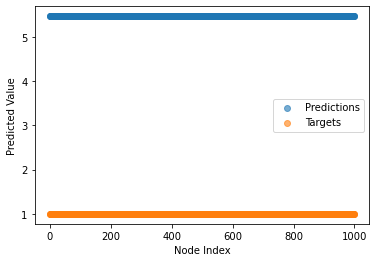

In [9]:
import matplotlib.pyplot as plt
import torch

# Ensure predictions is a PyTorch tensor before creating the target tensor
if not isinstance(predictions, torch.Tensor):
    predictions_tensor = torch.tensor(predictions, dtype=torch.float32, device=device)
else:
    predictions_tensor = predictions  # Already a tensor

# Create the target tensor before conversion
targets_tensor = torch.ones_like(predictions_tensor)

# Convert both to NumPy
predictions = predictions_tensor.cpu().numpy().flatten()
targets = targets_tensor.cpu().numpy().flatten()

# Plot
plt.scatter(range(len(predictions)), predictions, label="Predictions", alpha=0.6)
plt.scatter(range(len(targets)), targets, label="Targets", alpha=0.6)
plt.xlabel("Node Index")
plt.ylabel("Predicted Value")
plt.legend()
plt.show()
